In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pycbc.psd.analytical_space import *
import pycbc.noise
from pycbc.waveform import get_fd_det_waveform, get_td_det_waveform_from_fd_det
from pycbc.coordinates import TIME_OFFSET_20_DEGREES, lisa_to_ssb, ssb_to_lisa
from pycbc.filter.matchedfilter import sigma
from ldc.common.tools import aziPolAngleL2PsiIncl

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


# 1. Get source parameters

In [2]:
training_file = './LDC2_sangria_training_v2.h5'

fid = h5py.File(training_file)
names = fid["sky/mbhb/cat"].dtype.names
cat_mbhb = np.rec.fromarrays([np.array(fid["sky/mbhb/cat"][name]).squeeze() for name in names], names=names)
pd.DataFrame(cat_mbhb)

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance,ObservationDuration,Cadence
0,-0.564102,0.610927,0.908972,1.181699,0.972661,0.972862,1.015522e+06,7.968491e+05,4.800021e+06,4.275929,2.577539,4.094550,2.18186,17758.367941,3.155815e+07,3.0
1,-1.081082,4.052963,2.354232,1.689765,0.742128,0.989247,4.956676e+06,4.067167e+06,8.746488e+06,3.783309,0.963586,3.636925,6.17688,61097.116076,3.155815e+07,3.0
2,0.636028,0.779159,2.332027,2.065443,0.574122,0.592671,1.773563e+06,1.083356e+06,1.116784e+07,2.311127,0.232802,3.798411,6.03496,59472.237592,3.155815e+07,3.0
3,-0.878570,4.549720,2.068669,1.097989,0.942824,0.870789,9.159926e+05,7.017527e+05,1.125857e+07,1.150360,1.899782,5.829771,1.10396,7705.852640,3.155815e+07,3.0
4,-0.303004,1.292518,1.203136,2.097304,0.747377,0.838800,1.323277e+06,6.124855e+05,1.152694e+07,1.220197,2.691982,1.808398,1.73941,13470.983559,3.155815e+07,3.0
5,0.147296,5.986230,2.434152,1.926613,0.745574,0.546848,2.830218e+06,2.322253e+06,1.197096e+07,4.111379,1.131250,4.319761,5.50770,53474.693790,3.155815e+07,3.0
6,-0.987304,3.886726,2.594339,1.719446,0.829141,0.972219,3.204750e+06,3.056613e+06,1.361711e+07,3.628682,2.050928,1.084370,2.87966,24829.137775,3.155815e+07,3.0
7,0.917031,3.584892,1.665850,2.092903,0.988778,0.975945,1.856420e+06,1.801541e+06,1.653219e+07,1.866057,1.410068,0.527915,4.57261,43010.925050,3.155815e+07,3.0
8,0.835250,3.257316,2.362671,1.539846,0.833674,0.981901,3.983915e+06,2.049535e+06,1.724516e+07,1.578620,2.323179,3.643228,3.34910,29747.551597,3.155815e+07,3.0
9,-0.521369,3.085541,2.582941,2.200156,0.825883,0.811360,3.128823e+06,2.640346e+06,1.860576e+07,3.425317,2.604701,1.670016,7.21026,73048.167218,3.155815e+07,3.0


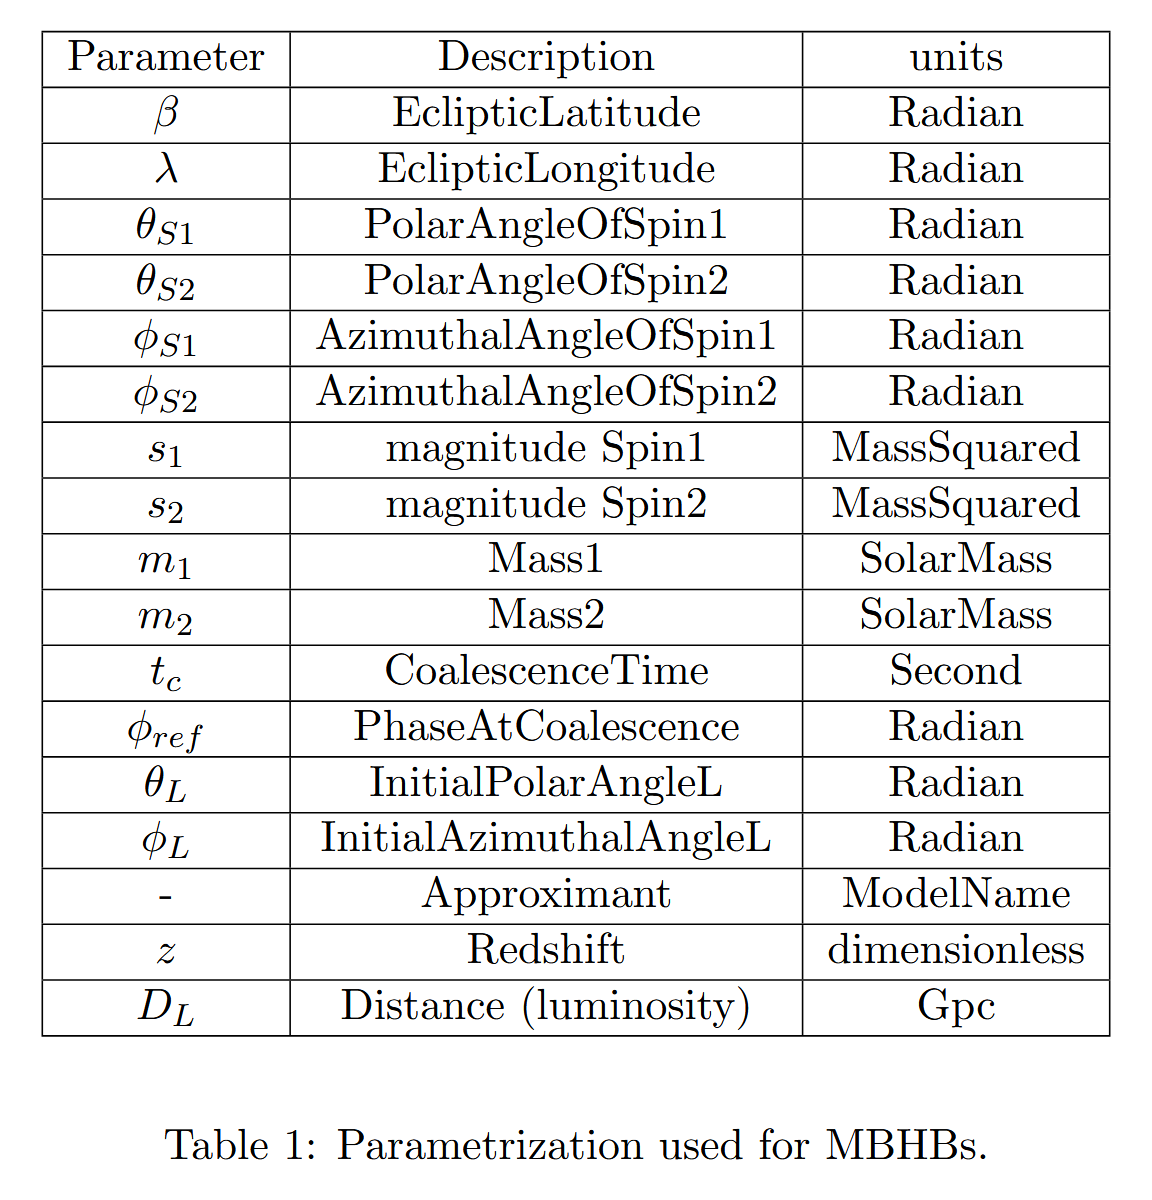

In [3]:
# def aziPolAngleL2PsiIncl(bet, lam, theL, phiL):
#     """
#     Convert polar and azimuthal angles of zS (typically orbital angular momentum L)
#     to polarisation and inclination (see doc)

#     Args:
#         bet (rad): ecliptic latitude of the source in sky
#         lam (rad): ecliptic longitude of the source in sky
#         theL (rad): polar angle of zS
#         phiL (rad): azimuthal angle of zS
#     """
#     inc = np.arccos( - np.cos(theL)*np.sin(bet) -\
#                      np.cos(bet)*np.sin(theL)*np.cos(lam - phiL) )
#     down_psi = np.sin(theL)*np.sin(lam - phiL)
#     up_psi = -np.sin(bet)*np.sin(theL)*np.cos(lam - phiL) +\
#              np.cos(theL)*np.cos(bet)
#     psi = np.arctan2(up_psi, down_psi)

#     return psi, inc

In [4]:
# get units
units = [(k, fid['sky/mbhb/cat'].attrs.get(k)) for k in names]
units = dict(units)
units

{'EclipticLatitude': 'rad',
 'EclipticLongitude': 'rad',
 'PolarAngleOfSpin1': 'rad',
 'PolarAngleOfSpin2': 'rad',
 'Spin1': '1',
 'Spin2': '1',
 'Mass1': 'Msun',
 'Mass2': 'Msun',
 'CoalescenceTime': 's',
 'PhaseAtCoalescence': 'rad',
 'InitialPolarAngleL': 'rad',
 'InitialAzimuthalAngleL': 'rad',
 'Redshift': '1',
 'Distance': 'Mpc',
 'ObservationDuration': None,
 'Cadence': None}

# 2. Get noiseless TDI data

In [5]:
tdi = fid["sky/mbhb/tdi"][()]

Text(0.5, 0, 'Time [s]')

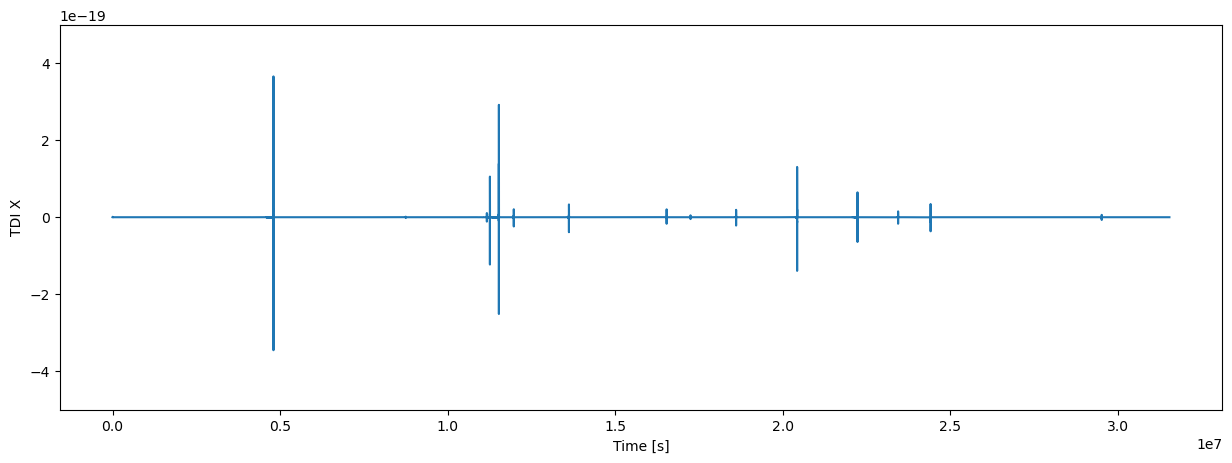

In [6]:
plt.figure(figsize=(15,5))
plt.plot(tdi['t'], tdi["X"])
plt.axis([None, None, -0.5e-18, 0.5e-18])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")

In [7]:
import xarray as xr
X = xr.DataArray(tdi['X'].squeeze(), coords=[("t", tdi['t'].flatten())])
Y = xr.DataArray(tdi['Y'].squeeze(), coords=[("t", tdi['t'].flatten())])
Z = xr.DataArray(tdi['Z'].squeeze(), coords=[("t", tdi['t'].flatten())])
print(X)

<xarray.DataArray (t: 6307200)> Size: 50MB
array([ 3.62700534e-22,  6.14763344e-22,  1.08330305e-21, ...,
       -5.82080396e-26, -5.81629209e-26, -5.81184036e-26])
Coordinates:
  * t        (t) float64 50MB 0.0 5.0 10.0 ... 3.154e+07 3.154e+07 3.154e+07


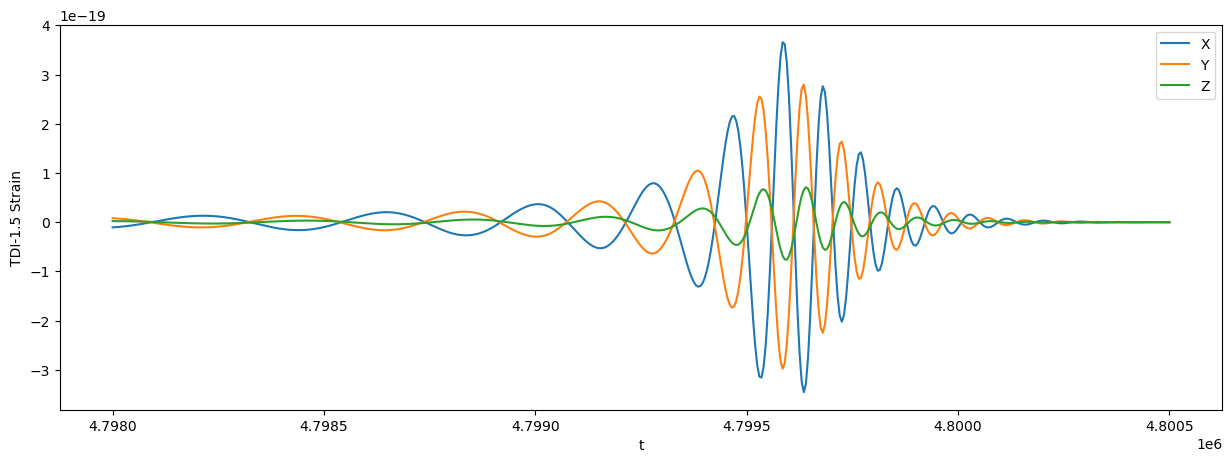

In [8]:
# data selection along time coordinate
ds = xr.Dataset({'X':X, 'Y':Y, 'Z':Z})
first_merger = ds.sel(t=slice(4798000, 4800500))
plt.figure(figsize=(15,5))
first_merger['X'].plot(label="X")
first_merger['Y'].plot(label="Y")
first_merger['Z'].plot(label="Z")
plt.ylabel('TDI-1.5 Strain')
plt.legend()

$$
E=\frac{X-2 Y+Z}{\sqrt{6}}, \quad A=\frac{Z-X}{\sqrt{2}}, \quad T=\frac{X+Y+Z}{\sqrt{3}}
$$

In [9]:
def xyz_to_aet(x, y, z):
    a = (z-x) / np.sqrt(2)
    e = (x-2*y+z) / np.sqrt(6)
    t = (x+y+z) / np.sqrt(3)
    return (a, e, t)

In [10]:
first_merger['A'], first_merger['E'], first_merger['T'] = xyz_to_aet(first_merger['X'], first_merger['Y'], first_merger['Z'])

In [11]:
first_merger

<xarray.Dataset> Size: 28kB
Dimensions:  (t: 501)
Coordinates:
  * t        (t) float64 4kB 4.798e+06 4.798e+06 4.798e+06 ... 4.8e+06 4.8e+06
Data variables:
    X        (t) float64 4kB -1.044e-20 -1.018e-20 ... -1.058e-22 -1.321e-22
    Y        (t) float64 4kB 8.181e-21 7.936e-21 ... 9.965e-23 1.164e-22
    Z        (t) float64 4kB 2.256e-21 2.244e-21 ... 6.495e-24 1.563e-23
    A        (t) float64 4kB 8.976e-21 8.786e-21 ... 7.944e-23 1.045e-22
    E        (t) float64 4kB -1.002e-20 -9.72e-21 ... -1.219e-22 -1.426e-22
    T        (t) float64 4kB -5.246e-26 -5.708e-26 ... 1.72e-25 -1.993e-26

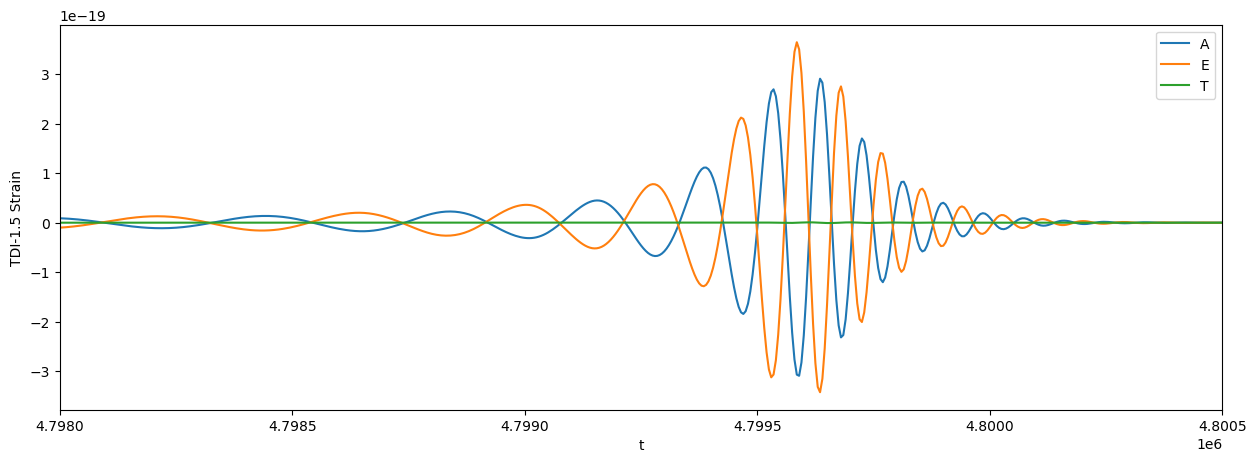

In [12]:
plt.figure(figsize=(15,5))
first_merger['A'].plot(label="A")
first_merger['E'].plot(label="E")
first_merger['T'].plot(label="T")
plt.xlim(4798000, 4800500)
plt.ylabel('TDI-1.5 Strain')
plt.legend()

# 3. Waveforms comparison with PyCBC

In [13]:
cat_mbhb[0]

(-0.56410239, 0.61092685, 0.90897235, 1.18169945, 0.972661, 0.972862, 1015522.4376, 796849.1091, 4800021.15572853, 4.27592931, 2.57753889, 4.09455023, 2.18186, 17758.36794127, 31558149.7635456, 3.)

In [14]:
names

('EclipticLatitude',
 'EclipticLongitude',
 'PolarAngleOfSpin1',
 'PolarAngleOfSpin2',
 'Spin1',
 'Spin2',
 'Mass1',
 'Mass2',
 'CoalescenceTime',
 'PhaseAtCoalescence',
 'InitialPolarAngleL',
 'InitialAzimuthalAngleL',
 'Redshift',
 'Distance',
 'ObservationDuration',
 'Cadence')

In [20]:
cat_mbhb[0]['Mass1']

1015522.4376

## The spin used for the IMRPhenomD model are computed as ai = si cos θSi.

In [18]:
# set parameters
params = {}
params['ref_frame'] = 'SSB'
params['approximant'] = 'BBHX_PhenomD'
params['coa_phase'] = cat_mbhb[0]['PhaseAtCoalescence']
params['mass1'] = cat_mbhb[0]['Mass1']
params['mass2'] = cat_mbhb[0]['Mass2']
params['spin1z'] = cat_mbhb[0]['Spin1'] * np.cos(cat_mbhb[0]['PolarAngleOfSpin1'])
params['spin2z'] = cat_mbhb[0]['Spin2'] * np.cos(cat_mbhb[0]['PolarAngleOfSpin2'])
params['distance'] = cat_mbhb[0]['Distance']
params['eclipticlongitude'] = cat_mbhb[0]['EclipticLongitude']
params['eclipticlatitude'] = cat_mbhb[0]['EclipticLatitude']
# These are not psi and inclination!
# params['polarization'] = cat_mbhb[0]['InitialPolarAngleL']
# params['inclination'] = cat_mbhb[0]['InitialAzimuthalAngleL']
params['polarization'], params['inclination'] = aziPolAngleL2PsiIncl(params['eclipticlatitude'], params['eclipticlongitude'],
                                                                     cat_mbhb[0]['InitialPolarAngleL'], cat_mbhb[0]['InitialAzimuthalAngleL'])
params['polarization'] = np.mod(params['polarization'], 2*np.pi)
params['tc'] = cat_mbhb[0]['CoalescenceTime']
params['t_obs_start'] = cat_mbhb[0]['ObservationDuration']
params['f_lower'] = 1e-4
params['f_ref'] = 1e-4
params['f_final'] = 0.1
params['delta_t'] = cat_mbhb[0]['Cadence']
params['delta_f'] = 1/params['t_obs_start']
# params['t_offset'] = TIME_OFFSET_20_DEGREES
params['t_offset'] = 0.0

In [19]:
# generate frequency-domain TDI waveform
bbhx_fd_tdi_1p5 = get_fd_det_waveform(ifos=['LISA_A','LISA_E','LISA_T'], tdi='1.5', **params)
bbhx_fd_tdi_2p0 = get_fd_det_waveform(ifos=['LISA_A','LISA_E','LISA_T'], tdi='2.0', **params)

# generate time-domain TDI waveform
bbhx_td_tdi_1p5 = get_td_det_waveform_from_fd_det(ifos=['LISA_A','LISA_E','LISA_T'], tdi='1.5', **params)

/work/shichao.wu/anaconda3/envs/bbhx_env/lib/python3.9/site-packages/BBHX_Phenom.py:74: UserWarning: Waveform duration is too short! Setting it to 1 month (2678400 s).
  warn("Waveform duration is too short! Setting it to 1 month (2678400 s).")
/work/shichao.wu/anaconda3/envs/bbhx_env/lib/python3.9/site-packages/BBHX_Phenom.py:287: RuntimeWarning: Input 'f_lower' is lower than the value calculated from 't_obs_start'.
  warn(err_msg, RuntimeWarning)


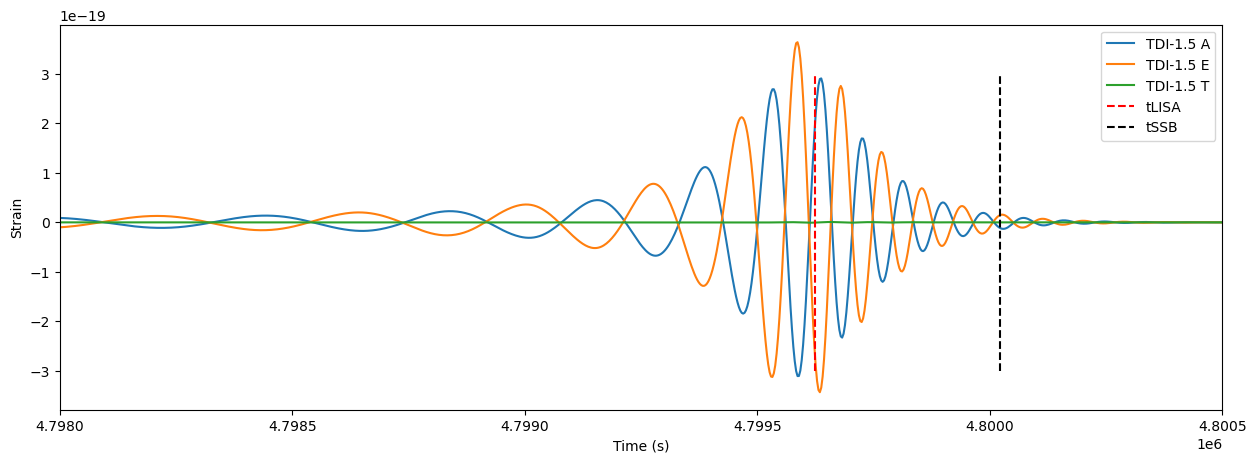

In [20]:
# get the merge time in LISA frame as a comparison
tLISA, _, _, _ = ssb_to_lisa(params['tc'], params['eclipticlongitude'], 
                             params['eclipticlatitude'], params['polarization'],
                             params['t_offset'])

plt.figure(figsize=(15,5))
plt.plot(bbhx_td_tdi_1p5['LISA_A'].sample_times, bbhx_td_tdi_1p5['LISA_A'], label='TDI-1.5 A')
plt.plot(bbhx_td_tdi_1p5['LISA_E'].sample_times, bbhx_td_tdi_1p5['LISA_E'], label='TDI-1.5 E')
plt.plot(bbhx_td_tdi_1p5['LISA_T'].sample_times, bbhx_td_tdi_1p5['LISA_T'], label='TDI-1.5 T')

plt.vlines(x=tLISA, ymin=-3e-19, ymax=3e-19, colors='red', linestyles='dashed', label='tLISA')
plt.vlines(x=params['tc'], ymin=-3e-19, ymax=3e-19, colors='k', linestyles='dashed', label='tSSB')
plt.xlim(4798000, 4800500)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

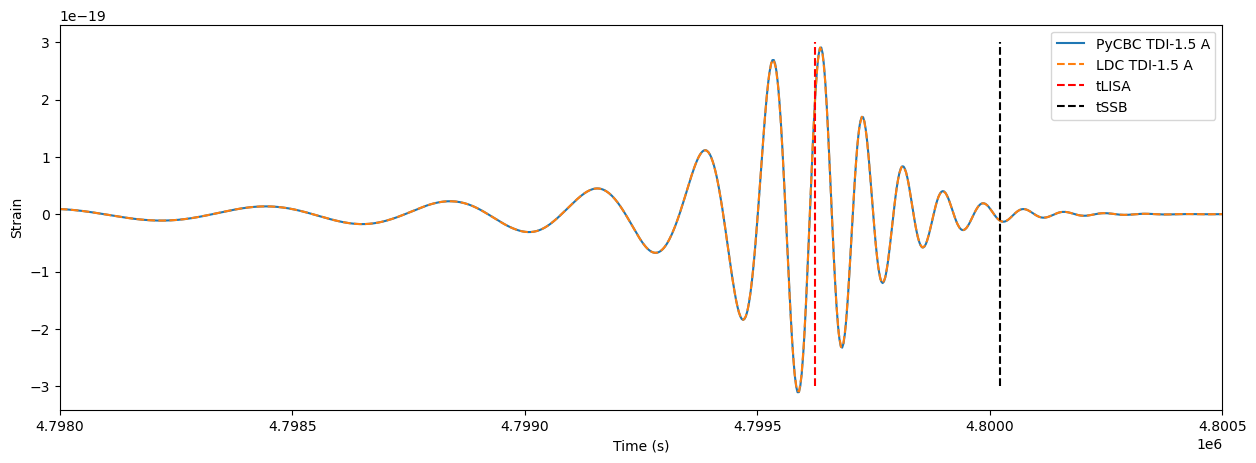

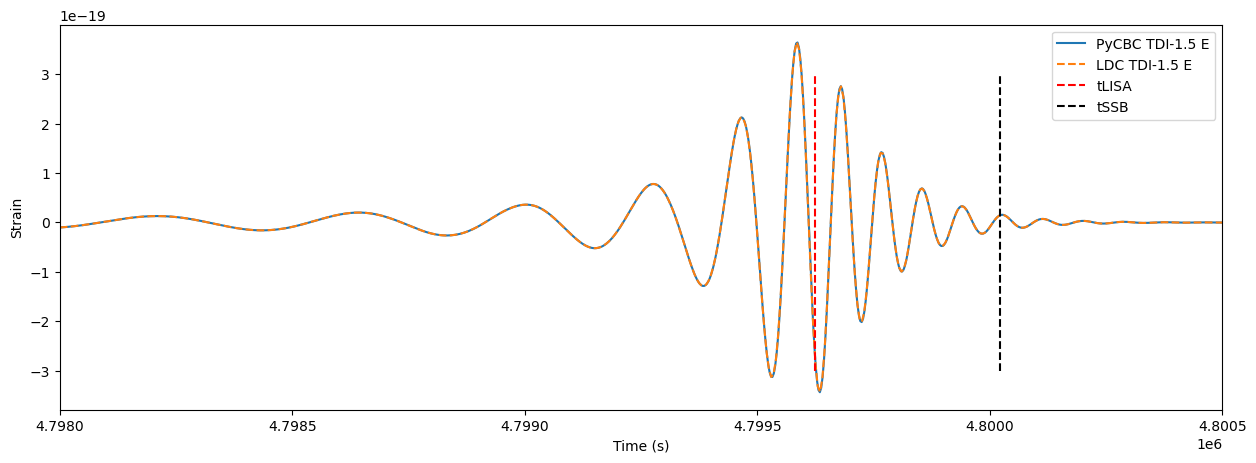

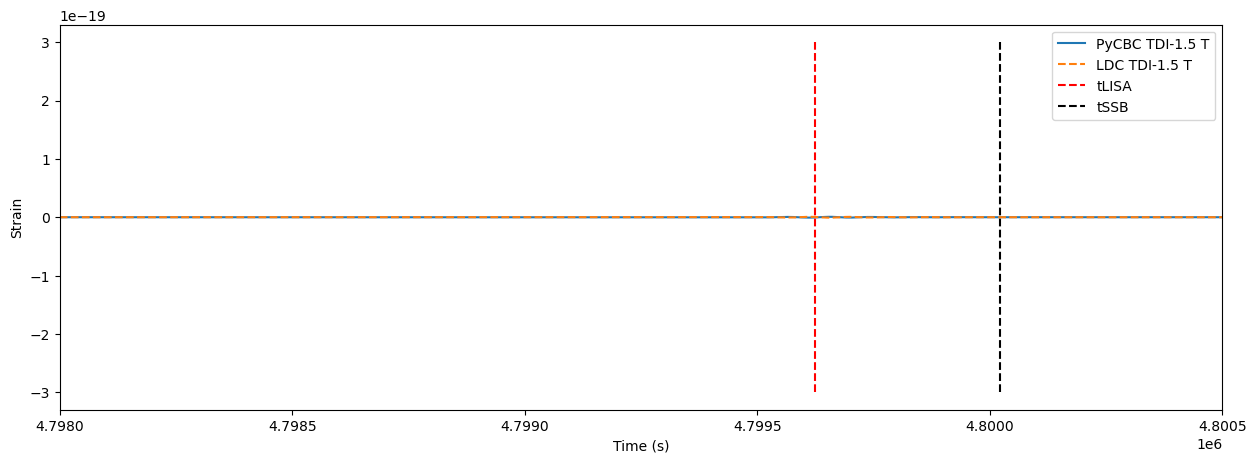

In [25]:
for channel in ['A', 'E', 'T']:
    plt.figure(figsize=(15,5))
    plt.plot(bbhx_td_tdi_1p5['LISA_%s' % channel].sample_times, bbhx_td_tdi_1p5['LISA_%s' % channel], label='PyCBC TDI-1.5 %s' % channel)
    plt.plot(first_merger['%s' % channel].t, first_merger['%s' % channel], label='LDC TDI-1.5 %s' % channel, linestyle='dashed')
    plt.vlines(x=tLISA, ymin=-3e-19, ymax=3e-19, colors='red', linestyles='dashed', label='tLISA')
    plt.vlines(x=params['tc'], ymin=-3e-19, ymax=3e-19, colors='k', linestyles='dashed', label='tSSB')
    plt.xlim(4798000, 4800500)
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")
    plt.legend()
    plt.show()